# Introduction to Deep Learning - Project

By Blasco Coll Roser, García Díaz Antonio, and Novella Ruiz Sergi.

Universitat Politècnica de Catalunya, 2019.

Link to the presentation: https://docs.google.com/presentation/d/e/2PACX-1vTqy225Aqv-yW2KhLEOoXG2sExrTONZGWHdlwcvnVeWyDdJRSV-HJBEMN9iReAFco0QkxP7266Bvpoq/pub?start=false&loop=false&delayms=60000

## Introduction

This notebook illustrates the influence of **pooling-related hyperparameters** on the performance of convolutional neural networks (ConvNets).

ConvNets are a class of deep artificial neural networks (NN) that are often used for analysing and processing image data, although they have also been used for processing other kinds of input (such as text and audio). This kind of network is designed as a succession of layers, inside which several convolution filters (most often learnt through training) treat their layer's input data to output feature maps.

Most ConvNets use so-called **pooling layers** in between their convolution filters. These layers use subsampling methods to reduce the dimensionality of a layer's output, and to make the network invariant to small local changes in inputs (which could have a negative impact on the performance of the network). They operate by picking up small clusters of input channels (i.e. groups of "pixels") and using them to produce a single output channel.

A pooling layer is mainly defined by the method it uses for selecting clusters of channels, and by the pooling operation that it performs on them. The former is commonly determined by a fixed area size and stride, as in a convolutional filter. As for the latter, several kinds of pooling layers have been defined, among which are the following:

* The **maximum (or max) pooling** layer (pictured below): selects the input channel with the maximum value, and copies that value to the output channel.
* The **average pooling** layer: calculates the average value of all the input channels in the cluster, and passes it through the output channel.
* The **power-average pooling** (or $L_p$ pooling) layer: the output is the $L_p$ distance for the cluster's input channels. For the channels of a cluster $X$, and for a given power $p$, this distance is given by the following function:
\begin{equation}
L_p(X) = \sqrt[p]{\sum_{x \in X} x^{p}}
\end{equation}
A power $p$ with value 1 corresponds to **sum pooling** (which behaves like average pooling), while a $p$ with infinite value corresponds to max pooling. 
* **Adaptive versions of pooling layers**: these layers perform the same operation as their non-adaptive counterparts (e.g. max pooling or average pooling) except that the cluster selection method is not defined beforehand. Instead, the size of the output feature maps is given, and feature clusters are defined automatically.
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="400">

## Methodology

In these experiments, different kinds of pooling operations and different sizes and strides of pooling filters were tested on a simple ConvNet. The network was used for a multiclass classification task (namely that of the [**MNIST dataset**](https://en.wikipedia.org/wiki/MNIST_database)). The MNIST dataset contains greyscale images representing handwritten digits (numbers from 0 to 9). Each digit image is 28x28 pixels and is labeled with the digit it contains.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="600">

The network is designed as a feed-forward scheme with two convolution layers followed by two fully connected layers. It is arranged in the following fashion:

1.   The input images are sent to a **first convolutional layer**, with 20 kernels of size 5 and stride 1. The output is thus made of 20 feature maps of 24x24 pixels. The **ReLU** activation function is applied on each pixel in the maps.
2.   The feature maps are reduced through a **first pooling layer** to a size of 12x12 pixels. In non-adaptive cases, the pooling layer uses a window of size 2 and stride 2 to pick clusters.
3.   The reduced feature maps are sent through a **second convolutional layer**, with 50 kernels of size 5 and stride 1. The output is made of 50 feature maps, by default of 8x8 pixels. The **ReLU** activation function is once again applied on each pixel.
4.   The resulting feature maps are sent through a **second pooling layer** to achieve a size of 4x4 pixels. The window is also of size 2 and stride 2 if the filter is not adaptive.
5.   The current feature maps are flattened, by concatenation, into a single vector. Its content is sent through a **first fully-connected layer** with an output of 500 channels. The **ReLU** activation function is applied on these channels.
6.   The data is sent through a **second fully-connected** layer with an output of size 10 (one output channel for each digit, from 0 to 9). The final predicted probabilities for each digit is obtained by applying a **softmax** operation on these 10 outputs.

The code for building this network was derived from [the PyTorch basic MNIST example](https://github.com/pytorch/examples/tree/master/mnist).





In [ ]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Experimental setup

### ConvNet Model initialization

ConvNet models for this research task are initialised in the standard PyTorch way, by creating a class that inherits from `torch.nn.Module`.

**In the `__init__` method**, the network's layers are created and stored as member variables. As previously explained, all tested networks contain two convolutional filters and two fully-connected layers, performing operations as defined in the above methodology.

Each convolutional filter is followed by a pooling layer, whose type is specified by another member variable: an **identifier number** passed as an initialization parameter. Each of these identifiers corresponds to a kind of pooling layer:
*   Number 0 corresponds to a **max pooling**.
*   Number 1 corresponds to an **average pooling**.
*   Number 2 corresponds to an **adaptative max pooling**.
*   Number 3 corresponds to an **adaptative average pooling**.
*   Number 4 corresponds to a **sum pooling** (a power-average pooling of power 1).
*   Number 5 corresponds to a **power-average pooling** of power **2**.
*   Number 6 or higher corresponds to a **power-average pooling** of power **1.2**.

**In the `forward` method**, the forward pass computation is implemented by making use of the layers stored by constructor `__init__` method.

In addition, **a new `pool_switch` method** is used to select the kind of pooling layers that will be added after the convolutions, based on the previously mentionned identifiers.

In [2]:
class Net(nn.Module):
    def __init__(self, pool1, pool2):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.pool1 = pool1
        self.pool1 = pool2
    
    def pool_switch(self, x, pool_id, output_size):
      if pool_id == 0:
        x = F.max_pool2d(x, 2, 2)
      elif pool_id == 1:
        x = F.avg_pool2d(x, 2, 2)
      elif pool_id == 2:
        x = F.adaptive_max_pool2d(x, output_size)
      elif pool_id == 3:
        x = F.adaptive_avg_pool2d(x, output_size)
      elif pool_id == 4:
        x = F.lp_pool2d(x, 1, 2, 2)
      elif pool_id == 5:
        x = F.lp_pool2d(x, 2, 2, 2)
      else:
        x = F.lp_pool2d(x, 1.2, 2, 2)
      return x

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool_switch(x, pool1, 12)
        x = F.relu(self.conv2(x))
        x = self.pool_switch(x, pool2, 4)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Training and evaluation functions

The training and evaluation (validation) functions are mostly unchanged from the original PyTorch example. The calculated loss values, however, are stored in a list and returned at the end of each function. The `print` instruction to check the training and validation process directly is also commented out, as it is not used.

N.B.: The loss function is the **negative log likelihood** (NLL), as it is often the case for a multiclass classification problem.

In [3]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
    return losses

def validate(model, device, loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    validation_loss /= len(loader.dataset)
    # print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     validation_loss, correct, len(loader.dataset),
    #     100. * correct / len(loader.dataset)))
    return validation_loss

### Downloading and preprocessing the dataset

The MNIST dataset is loaded from `torchvision`. PyTorch loaders are used to get iterators to the training and validation batches. The size of the training batches is of 128 examples per batch, while that of the validation batches is of 1000 examples. The data is also preprocessed: a linear transformation is applied to normalize the data.

In [4]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

Processing...
Done!


## Experiments and discussion

The experiments consist in comparing different ConvNets that share the same overall structure (as described in the methodology), but with different types of pooling layers (as enabled by the `pool_switch` method mentionned above). In total, **49 combinations of layers** are compared (7 kinds of layer for the first pooling layer, and the same 7 kinds for the second one).

Each ConvNet represented by a combination of pooling layers is created and trained **3 times**, and the evolution of the validation loss over time is charted in each of these 3 repetitions. Then, these evolutions of the loss are used to calculate the evolution of **mean and standard deviation** of the loss.

The final value of the mean and standard deviation (the last value in time) is placed in a 7x7 matrix, with all the values from the 79 other combinations. In addition, if the final mean loss was among the top 5 losses, the evolution data remains stored and is later used to build a graph.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean_valid_losses = []  # Is a 7x7 matrix.
std_valid_losses = []   # Is a 7x7 matrix.
top5_valid_loss_ev = []
valid_x = []
num_epochs = 10

for pool1 in range(7):
    mean_valid_losses.append([])
    std_valid_losses.append([])

    for pool2 in range(7):
        all_valid_loss_ev = []

        for repetition in range(3):
            model = Net(pool1, pool2).to(device)
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

            train_loss_ev = []
            all_valid_loss_ev.append([])

            for epoch in range(1, num_epochs + 1):
                curr_epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
                train_loss_ev.extend(curr_epoch_losses)

                curr_valid_loss = validate(model, device, valid_loader)
                all_valid_loss_ev[-1].append(curr_valid_loss)

                # The x values for validation only need to be defined once.
                if pool1 == 0 and pool2 == 0 and repetition == 0:
                    valid_x.append(len(train_loss_ev) - 1)

            print("End", pool1, pool2, repetition, "!")

        # Calculate the evolution of the mean and std of the loss value.
        mean_valid_loss_ev = np.mean(all_valid_loss_ev, axis=0)
        std_valid_loss_ev = np.std(all_valid_loss_ev, axis=0)

        # Add the latest mean and std values to their respective tables.
        mean_valid_losses[-1].append(mean_valid_loss_ev[-1])
        std_valid_losses[-1].append(std_valid_loss_ev[-1])

        # Add mean and std evolution to the top 5 validation losses.
        top5_valid_loss_ev.append(
            [(pool1, pool2), mean_valid_loss_ev, std_valid_loss_ev])
        if len(top5_valid_loss_ev) > 5:
            # Sort elements by the latest (mean) loss value, delete the last element.
            top5_valid_loss_ev.sort(key=lambda x: x[1][-1])
            del top5_valid_loss_ev[-1]

End 0 0 0 !
End 0 0 1 !
End 0 0 2 !
End 0 1 0 !
End 0 1 1 !
End 0 1 2 !
End 0 2 0 !
End 0 2 1 !
End 0 2 2 !
End 0 3 0 !
End 0 3 1 !
End 0 3 2 !
End 0 4 0 !
End 0 4 1 !
End 0 4 2 !
End 0 5 0 !
End 0 5 1 !
End 0 5 2 !
End 0 6 0 !
End 0 6 1 !
End 0 6 2 !
End 1 0 0 !
End 1 0 1 !
End 1 0 2 !
End 1 1 0 !
End 1 1 1 !
End 1 1 2 !
End 1 2 0 !
End 1 2 1 !
End 1 2 2 !
End 1 3 0 !
End 1 3 1 !
End 1 3 2 !
End 1 4 0 !
End 1 4 1 !
End 1 4 2 !
End 1 5 0 !
End 1 5 1 !
End 1 5 2 !
End 1 6 0 !
End 1 6 1 !
End 1 6 2 !
End 2 0 0 !
End 2 0 1 !
End 2 0 2 !
End 2 1 0 !
End 2 1 1 !
End 2 1 2 !
End 2 2 0 !
End 2 2 1 !
End 2 2 2 !
End 2 3 0 !
End 2 3 1 !
End 2 3 2 !
End 2 4 0 !
End 2 4 1 !
End 2 4 2 !
End 2 5 0 !
End 2 5 1 !
End 2 5 2 !
End 2 6 0 !
End 2 6 1 !
End 2 6 2 !
End 3 0 0 !
End 3 0 1 !
End 3 0 2 !
End 3 1 0 !
End 3 1 1 !
End 3 1 2 !
End 3 2 0 !
End 3 2 1 !
End 3 2 2 !
End 3 3 0 !
End 3 3 1 !
End 3 3 2 !
End 3 4 0 !
End 3 4 1 !
End 3 4 2 !
End 3 5 0 !
End 3 5 1 !
End 3 5 2 !
End 3 6 0 !
End 3 6 1 !
End 

<Figure size 432x288 with 0 Axes>

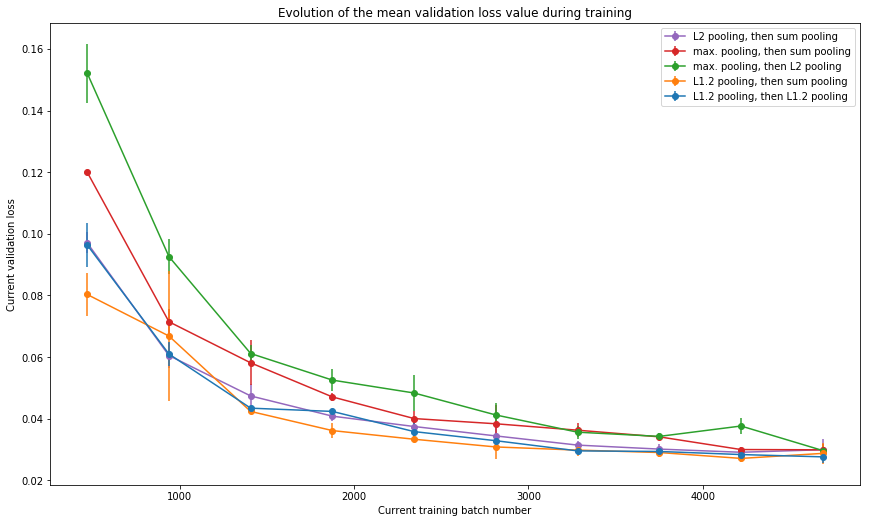

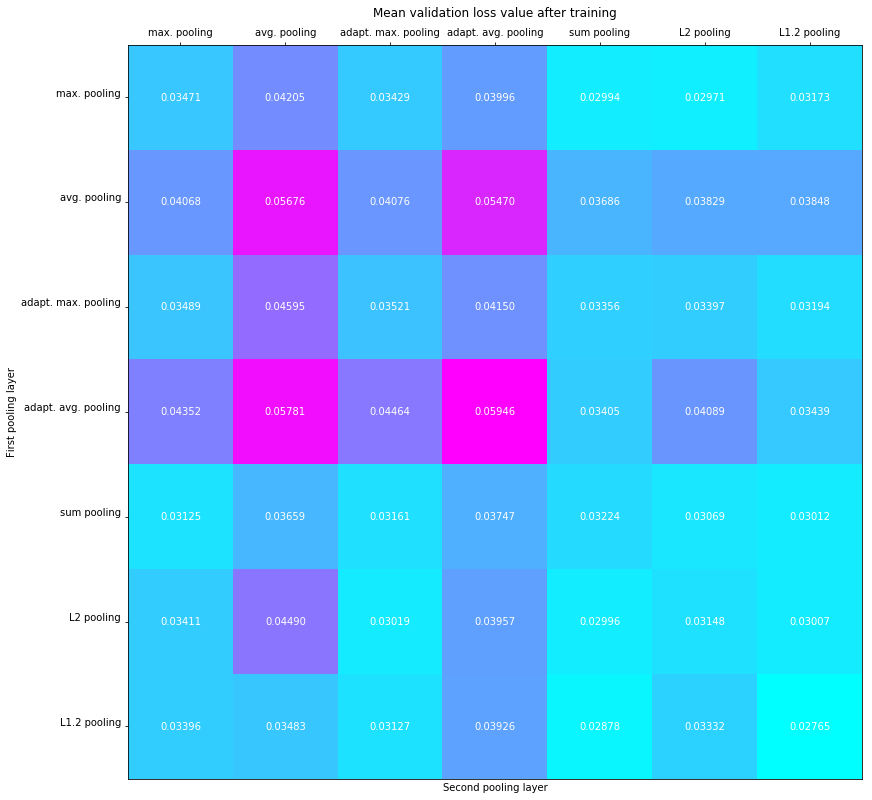

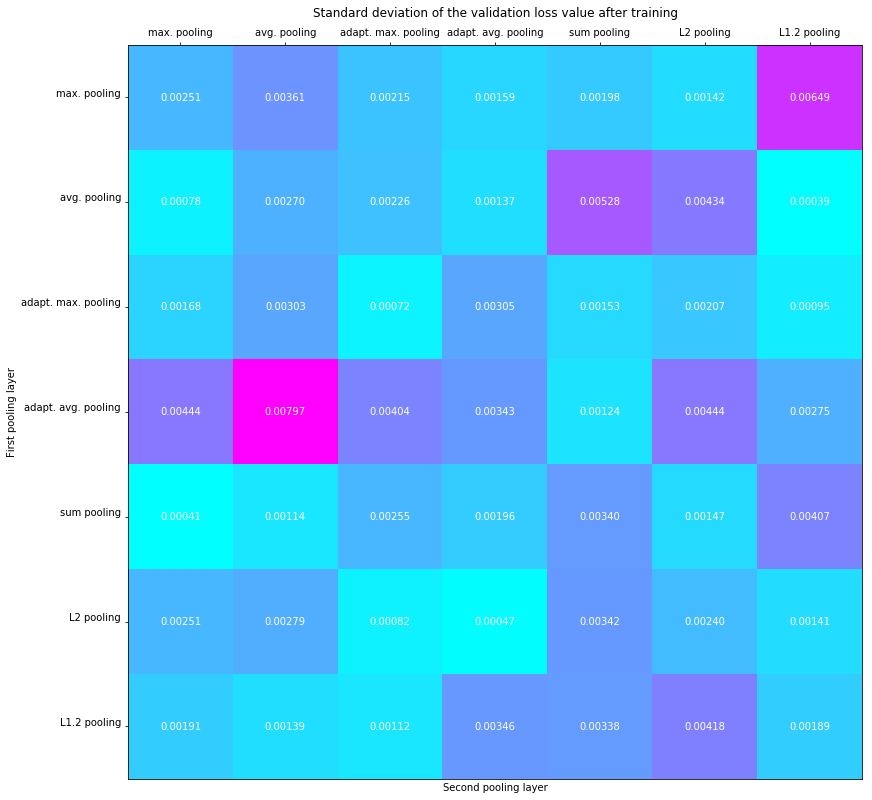

In [68]:
pooling_layers = ["max. pooling", "avg. pooling", "adapt. max. pooling", "adapt. avg. pooling",
                  "sum pooling", "L2 pooling", "L1.2 pooling"]
plt.gcf().clear()


# The iteration over the top 5 is from worst to best.
plt.figure(figsize=(14.5, 8.5))
for topnum in range(4, -1, -1):
  plt.errorbar(valid_x, top5_valid_loss_ev[topnum][1],
               yerr=top5_valid_loss_ev[topnum][2], fmt='C'+str(topnum)+'o-',
               label=pooling_layers[top5_valid_loss_ev[topnum][0][0]]+', then '+pooling_layers[top5_valid_loss_ev[topnum][0][1]])
plt.title("Evolution of the mean validation loss value during training")
plt.xlabel("Current training batch number")
plt.ylabel("Current validation loss")
plt.legend(loc='upper right')
plt.show()


# Heatmap code adapted from:
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
fig, ax = plt.subplots()
im = ax.imshow(mean_valid_losses, cmap="cool", origin='upper')
# Set x and y ticks and their labels.
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(pooling_layers)
ax.set_yticklabels(pooling_layers)
ax.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
# Set labels for data in boxes.
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, '%.5f' % mean_valid_losses[i][j],
                       ha="center", va="center", color="w")
# Last few settings.
ax.set_title("Mean validation loss value after training", y=1.03)
ax.set_xlabel("Second pooling layer")
ax.set_ylabel("First pooling layer")
fig.set_size_inches(20.5, 13.5)
plt.show()


# Heatmap code adapted from:
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
fig, ax = plt.subplots()
im = ax.imshow(std_valid_losses, cmap="cool", origin='upper')
# Set x and y ticks and their labels.
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(pooling_layers)
ax.set_yticklabels(pooling_layers)
ax.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
# Set labels for data in boxes.
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, '%.5f' % std_valid_losses[i][j],
                       ha="center", va="center", color="w")
# Last few settings.
ax.set_title("Standard deviation of the validation loss value after training", y=1.03)
ax.set_xlabel("Second pooling layer")
ax.set_ylabel("First pooling layer")
fig.set_size_inches(20.5, 13.5)
plt.show()

The above code builds two figures: a graph of the evolution of the mean validation loss for the 5 best performing architectures, and a heatmap of the final validation loss values for all the tested architectures.

From this data, it can be observed that the best performing architectures are those that use **max pooling** (especially in the first pooling layer) and/or a form of **$L_p$ pooling** (including sum pooling). Architectures that use average pooling, adaptative or otherwise, do not seem to perform as well as the other ones. In addition, it can be seen that adaptative versions of pooling methods perform similarly to their non-adaptative counterparts.

## Conclusion

It can be concluded that, at least in this scenario, **using average pooling (adaptive or otherwise) is not a good idea**, since networks using this kind of pooling do not perform as well as other tested networks. Rather, it seem that using max pooling or $L_p$ pooling after a network's convolutional layers provides much better results in terms of loss.

The better performance of max pooling over average pooling may be due to the nature of the MNIST dataset. This set is made of images of handwritten black digits over a white background. This sharp contrast tends to be useful when applying convolutional filters to detect **borders**, as these will result in **larger values** on the feature maps. **The max pooling operation preserves larger values** while reducing the size of feature maps, while **the average pooling operation tends to blur them**. Since borders are very useful to distinguish between filters, it is thus understandable that max pooling provides the best performance out of the two.

Perhaps also the better performance of $L_p$ pooling can be explained in a similar way. The reason why these pooling methods perform better than average pooling might be that, unlike the latter, **they do not normalize their output**. This is most striking in the case of sum pooling ($L_p$ pooling with $p=1$), which has got a similar formula to average pooling but performs much better in terms of loss. The difference is that, in average pooling, the result of the sum is divided by the number of input channels (pixels), which has the effect of **lowering the output value** and further "blurring" it.